# Setting Up the Notebook

Before proceeding with the creation of the dataset needed for the experiment, we need to install and import some libraries. More specifically, we need to install the Python library that allows to read NIFTI images (the format in which the PET scans are stored).

In [ ]:
!pip install nibabel p_tqdm 2>&1 >/dev/null

In [ ]:
import glob
import re
import sys

import cv2
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import yaml
from p_tqdm import p_uimap

We can then proceed with the mounting of the Google Drive folder, that will be needed later to actually use the data. Here, we've chosen as mountpoint the `/datasets/drive` folder.

In [ ]:
!mkdir /datasets -p
from google.colab import drive

drive.mount("/datasets/drive", force_remount=True)

Mounted at /datasets/drive


We can now set some variables for ensuring the reproducibility of the experiment and the readability of the code. More specifically, we'll set the path to the mounted Google Drive folder that contains the "raw" scans, as well as the random seed and a flag that tells if this is the first run of the notebook or not (so that it won't regenerate unneeded CSV files that may be different for each run).

In [ ]:
import os
import random
from pathlib import Path

DATA_DIR = Path("Your directory here")
RANDOM_SEED = 1234
random.seed(RANDOM_SEED)
FIRST_RUN = True

# Importing the Data

## Importing the CSV data

The OASIS 3 dataset provides different CSV files that contain various information about the visits of each patient. Here, we're importing them and we're fixing some of the errors that they contain (e.g., the CSVs implicitly contain information regarding the date and the subject, that we'll make explicit).

In [ ]:
subjects = pd.read_csv(DATA_DIR / "csv/subjects.csv")
clinical_data = pd.read_csv(DATA_DIR / "csv/clinical-data.csv")
pet_data = pd.read_csv(DATA_DIR / "csv/pet.csv")
pup_data = pd.read_csv(DATA_DIR / "csv/pup.csv")
mri_data = pd.read_csv(DATA_DIR / "csv/mri.csv")

# By default, the CSVs do not contain some information explicitly
# (although the columns have been defined). Thus, here we set them
# to usable values.

pup_data["Date"] = pup_data["PUP_PUPTIMECOURSEDATA ID"].apply(
    lambda s: int(s.split("_")[3][1:])
)
pup_data["Subject"] = pup_data["PUP_PUPTIMECOURSEDATA ID"].apply(
    lambda s: s.split("_")[0]
)

clinical_data["Date"] = clinical_data["ADRC_ADRCCLINICALDATA ID"].apply(
    lambda s: int(s.split("_")[2][1:])
)

pet_data["Tracer"] = pet_data["XNAT_PETSESSIONDATA ID"].map(lambda x: x.split("_")[1])

Thus, the composition of the dataset is as follows:

In [ ]:
print("Number of subjects:", subjects.shape[0])
print("Number of MRI scans:", mri_data.shape[0])
print("Number of PET scans:", pet_data.shape[0])
print("Number of PUP results:", pup_data.shape[0])

Number of subjects: 1098
Number of MRI scans: 2168
Number of PET scans: 1607
Number of PUP results: 1352


By looking more in details to the PET scans, the availability of scans for each tracer is as follows:

In [ ]:
pet_data["Tracer"].value_counts()

PIB     999
AV45    491
FDG     117
Name: Tracer, dtype: int64

Or, by grouping amyloid PET scans:

In [ ]:
(
    pet_data["Tracer"]
    .replace("PIB|AV45", "Amyloid", regex=True)
    .value_counts(normalize=True)
)

Amyloid    0.927194
FDG        0.072806
Name: Tracer, dtype: float64

Instead, if we refer to the already pre-processed PET scans, the composition of the dataset is as follows:

In [ ]:
pup_data["tracer"].value_counts()

PIB     935
AV45    417
Name: tracer, dtype: int64

# Labelling the Data

The OASIS3 dataset does not contain explicit labels for each PET scan. Thus a labelling phase is needed. We start by using the "clinical data" CSV file, that contains at most five differential diagnosis for each visit for each patient. Here, we'll normalize the format by replacing the "dots" as empty cells.

In [ ]:
clinical_data.replace({".": None, np.nan: None}, inplace=True)

We can now simplify the diagnosis by mapping each diagnosis to either 1 (meaning that the patient suffers from Alzheimer's or other similar diseases) or 0 (meaning that the patient is healthy or suffers from different diseases).

In [ ]:
labels = set()
for i in range(1, 6):
    labels = labels.union(clinical_data[f"dx{i}"].unique())
simplified = {
    str(k): re.match(
        "^(AD dem|Vasc.*? dem|Frontotemporal dem|other mental retarAD demion|(Active )?DLBD|Active PSNP|Dementia)",
        str(k),
        re.I,
    )
    is not None
    for k in labels
}
simplified = {
    k: v or re.match("^uncertain.*?dem", k) is not None for k, v in simplified.items()
}
# We classify uncertain cases as sick

Thus, by attaching the newly created diagnosis to the original CSV, we obtain the following distribution:

False    4691
True     1533
Name: dementia, dtype: int64

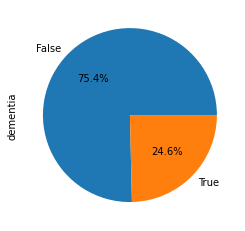

In [ ]:
clinical_data["dementia"] = (
    clinical_data[[f"dx{i}" for i in range(1, 6)]].replace(simplified).any(axis=1)
)
clinical_data["dementia"].value_counts().plot.pie(autopct="%1.1f%%")
clinical_data["dementia"].value_counts()

It is clear that, since dementia is a spectrum rather than a symptom, there may be some "uncertain" cases:

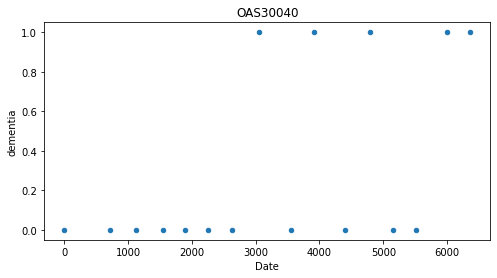

In [ ]:
subj = "OAS30040"
(
    clinical_data.groupby("Subject")
    .get_group(subj)
    .replace({True: 1, False: 0})
    .plot.scatter(x="Date", y="dementia", title=subj, figsize=(8, 4))
)
plt.show()

We thus apply a simple algorithm that tries to find and correct any such cases.

In [ ]:
clinical_data = clinical_data.sort_values(by=["Subject", "Date"]).reset_index(drop=True)
current_subj = None
for index, row in clinical_data.iterrows():
    if current_subj != row["Subject"]:
        current_subj = row["Subject"]
        prec = (None, None)  # i-2, i-1
        succ = (
            clinical_data.at[index + 1, "dementia"]
            if index + 1 in clinical_data.index
            and clinical_data.at[index + 1, "Subject"] == current_subj
            else None,
            clinical_data.at[index + 2, "dementia"]
            if index + 2 in clinical_data.index
            and clinical_data.at[index + 2, "Subject"] == current_subj
            else None,
        )

    if row["dementia"] == True:
        new = prec[1] or any(succ)
    else:
        new = any(prec) and any(succ)
    clinical_data.at[index, "dementia"] = new

    prec = (prec[1], new)  # i-1, i
    succ = (
        succ[1],
        clinical_data.at[index + 3, "dementia"]
        if index + 3 in clinical_data.index
        and clinical_data.at[index + 3, "Subject"] == current_subj
        else None,
    )

Applying this algorithm, the previous example becomes as follows (thus all false negatives have been fixed).

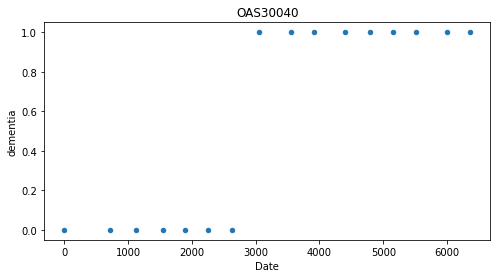

In [ ]:
subj = "OAS30040"
(
    clinical_data.groupby("Subject")
    .get_group(subj)
    .replace({True: 1, False: 0})
    .plot.scatter(x="Date", y="dementia", title=subj, figsize=(8, 4))
)
plt.show()

We can finally attach a label to each PET scan by associating the label of the nearest visit in time.

In [ ]:
labeled_dataset = pup_data.copy()
labeled_dataset.drop(
    columns=[
        "procType",
        "model",
        "templateType",
        "FSId",
        "mocoError",
        "regError",
        "Centil_fBP_TOT_CORTMEAN",
        "Centil_fSUVR_TOT_CORTMEAN",
        "Centil_fBP_rsf_TOT_CORTMEAN",
        "Centil_fSUVR_rsf_TOT_CORTMEAN",
    ],
    inplace=True,
)
labeled_dataset["Label"] = None
for index, row in labeled_dataset.iterrows():
    rows_of_subject = clinical_data.loc[clinical_data["Subject"] == row["Subject"]][
        ["Date", "dementia"]
    ]
    rows_of_subject["Date"] = rows_of_subject["Date"].apply(
        lambda x: abs(x - row["Date"])
    )
    labeled_dataset.at[index, "Label"] = (
        rows_of_subject.groupby(by="Date", as_index=False)
        .any()
        .sort_values(by="Date")
        .loc[0]["dementia"]
    )

labeled_dataset.to_csv(DATA_DIR / "csv" / "labeled_dataset.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Dealing with Class Imbalance

By plotting the composition of the dataset, it is clear that we're working with an heavily imbalanced dataset.

False    0.900148
True     0.099852
Name: Label, dtype: float64

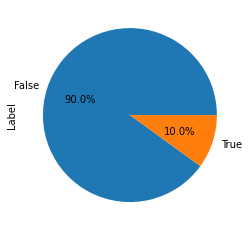

In [ ]:
labeled_dataset["Label"].value_counts().plot.pie(autopct="%1.1f%%")
labeled_dataset["Label"].value_counts(normalize=True)

In [ ]:
labeled_dataset.shape

(1352, 6)

To fix this issue, we apply a combination of random undersampling on negative samples and data augmentation on positive samples.

### Grouping scans by subject

Since many scans are associated to a single subject, in order to avoid future bias at training time, we decide to take only one scan for each subject. More specifically, we take the most recent scan take for a patient.

In [ ]:
new_dataset = labeled_dataset.sort_values(["Subject", "Date"], ascending=[True, True])
new_dataset.drop_duplicates(subset=["Subject"], keep="last", inplace=True)
new_dataset["Label"].value_counts()

False    618
True     112
Name: Label, dtype: int64

### Random Undersampling

We randomly select a subset of negative samples, by making sure that we try and keep as most data on the positive patients as possible. To ensure reproducibility, we save the selected negative samples to a CSV.

In [ ]:
!ls "$DATA_DIR/pet/all" | wc -l

262


In [ ]:
if FIRST_RUN:
    positive = new_dataset.loc[labeled_dataset["Label"] == True]
    positive.to_csv(DATA_DIR / "csv" / "new-positive.csv", index=False)
    negative = new_dataset.loc[labeled_dataset["Label"] == False]
    negative = negative.sample(n=150, random_state=RANDOM_SEED)
    negative.sort_values(["Subject"], ascending=[True], inplace=True)
    negative.to_csv(DATA_DIR / "csv" / "new-negative.csv", index=False)

    sampled = pd.concat([positive, negative])
    sampled.to_csv(DATA_DIR / "csv" / "new_sample.csv", index=False)
else:
    sampled = pd.read_csv(DATA_DIR / "csv" / "new_sample.csv")

The modified dataset composition becomes as follows:

False    150
True     112
Name: Label, dtype: int64

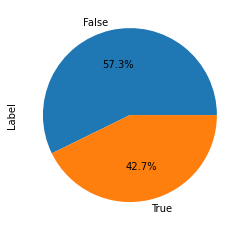

In [ ]:
sampled["Label"].value_counts().plot.pie(autopct="%1.1f%%")
sampled["Label"].value_counts()

### Data augmentation

To further reduce the unbalancing of the dataset, we augment the positive samples through the means of random rotations and flips.

Separating positive and negative scans into different folders


In [ ]:
sampled["Label"].value_counts()

False    148
True     105
Name: Label, dtype: int64

In [ ]:
sampled = pd.read_csv(DATA_DIR / "csv" / "pet_sample.csv")
pos = sampled["Subject"].loc[sampled["Label"] == True].values
neg = sampled["Subject"].loc[sampled["Label"] == False].values
pos[0]

'OAS30024'

In [ ]:
positive = [list(DATA_DIR.glob(f"pet/all/{s}*.img")) for s in pos]
pos_paths = [p for paths in positive for p in paths]
negative = [list(DATA_DIR.glob(f"pet/all/{s}*.img")) for s in neg]
neg_paths = [n for paths in negative for n in paths]
print(len(pos_paths), len(neg_paths))

105 148


In [ ]:
for p in pos_paths:
    !cp "$p" "$DATA_DIR/pet/positive"

In [ ]:
for n in neg_paths:
    !cp "$n" "$DATA_DIR/pet/negative"

In [ ]:
!ls "$DATA_DIR/pet/negative/" | wc -l

296


In [ ]:
from scipy.ndimage.interpolation import rotate


# This rotation fills the empty space in the corners with the mean of colours from the corner-patch
def rotate_img(img, angle, bg_patch=(5, 5)):
    assert len(img.shape) <= 3, "Incorrect image shape"
    rgb = len(img.shape) == 3
    if rgb:
        bg_color = np.mean(img[: bg_patch[0], : bg_patch[1], :], axis=(0, 1))
    else:
        bg_color = np.mean(img[: bg_patch[0], : bg_patch[1]])
    img = rotate(img, angle, reshape=False)
    mask = [img <= 0, np.any(img <= 0, axis=-1)][rgb]
    img[mask] = bg_color
    return img


def transform(img, fn):
    transformed = img.copy()
    for f in fn.split("|"):
        grp = re.match(r"^rotate:(-?\d+?)$", f)
        if grp:
            angle = int(grp.group(1))
            for i in range(transformed.shape[0]):
                transformed[i, :, :] = rotate_img(transformed[i, :, :], angle)
        elif f == "flipv":
            transformed = transformed[:, ::-1, :]
        elif f == "fliph":
            transformed = transformed[:, :, ::-1]
        else:
            raise ValueError(f"Illegal 'fn' value '{fn}'")
    return transformed

To ensure reproducibility, we save in a CSV a list of the randomly selected images that will be modified, as well as with the ordered list of operations that have been applied.

In [ ]:
if FIRST_RUN:
    pet_images = list(DATA_DIR.glob("pet/positive/*.hdr"))
    print(len(pet_images))
    pet_paths = random.sample(pet_images, k=43)
    mod_pet_df = pd.DataFrame(
        columns=["PUP_PUPTIMECOURSEDATA ID", "Date", "Subject", "Label"],
        index=np.arange(0, len(pet_paths)),
    )
    sampled = pd.read_csv(DATA_DIR / "csv" / "new_sample.csv")

    for i, path in enumerate(pet_paths):
        # Need to store both the .nii img and the one with mean,
        # so we can use the .nii for saving later
        try:
            nii_img = nib.load(path)
            img = np.mean(nii_img.get_fdata(), axis=3)
        except OSError:
            print("Error in reading", path, "(file could be damaged)", file=sys.stderr)
            break
        transformation_functions = random.choices(
            ["rotate", "flipv", "fliph"],
            weights=[0.5, 0.25, 0.25],
            k=random.randint(1, 5),
        )
        transformation_functions = [
            s + f":{random.randrange(-30, 30)}" if s == "rotate" else s
            for s in transformation_functions
        ]
        transform_string = "|".join(transformation_functions)
        # Get the file name without extension, the Date, the Subject and the transformations (to be replaced with Label)
        mod_pet_df.loc[i] = [
            os.path.basename(path).split(".")[0],
            sampled["Date"].loc[
                sampled["PUP_PUPTIMECOURSEDATA ID"]
                == os.path.basename(path).split(".")[0]
            ],
            os.path.basename(path).split("_")[0],
            transform_string,
        ]
        # Apply the transformation function(s)
        transformed_img = transform(np.array(img), transform_string)
        to_save_img = nib.Nifti1Image(transformed_img, nii_img.affine)
        # Save the new generated image (as: ORIGINALE_modID.4dfp.img)
        nib.save(
            to_save_img,
            DATA_DIR
            / "pet"
            / "modified"
            / (os.path.basename(path).split(".")[0] + f"_mod{i}.4dfp.nii"),
        )
        mod_pet_df.to_csv(DATA_DIR / "csv/modified-pet.csv")


else:
    mod_pet_df = pd.read_csv(DATA_DIR / "csv" / "modified-pet.csv")

105


/usr/local/lib/python3.7/dist-packages/pandas/core/internals/blocks.py:937: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


# Preparing the data

## Resizing the Images

To resize the images to a common size, we'll compute a bounding box of the brain (in order to center it) and we'll select the 20 middle slices of each PET scan. Thus, we start by defining a function to compute the bounding box using the Otsu threshold method.

In [ ]:
def find_brain_bounding_box(image):
    x, y, w, h = (image.shape[0] + 1, image.shape[1] + 1, -1, -1)
    for slice in image.T:
        blurred = cv2.GaussianBlur(slice.T, (13, 13), 150)
        blurred *= 255.0 / blurred.max()
        blurred[np.where(blurred < 0)] = 0
        blurred = blurred.astype(np.uint8)
        ret, thres = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        blurred_thres = cv2.medianBlur(thres, 5)
        contours, hierarchy = cv2.findContours(blurred_thres, 1, 2)
        curr_x, curr_y, curr_w, curr_h = cv2.boundingRect(contours[0])
        w = max(w, curr_x + curr_w)
        h = max(h, curr_y + curr_h)
        x = min(x, curr_x)
        y = min(y, curr_y)
    # provide a small padding around the found box:
    x = max(x - 10, 0)
    y = max(y - 10, 0)
    w = min(w + 10, image.shape[0])
    h = min(h + 10, image.shape[1])
    return x, y, w, h

We then define a function to normalize the images

In [ ]:
def normalize(volume):
    """Normalize the volume"""
    volume = np.array(volume)
    min = volume.min()
    max = volume.max()
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

And we define a function to resize the images to $(128, 128, 50)$ voxels.

In [ ]:
def resize_to_input_shape(img):
    shape = (128, 128)
    n_frames = 50
    # Starting index to extract the 50 central frames of the third dimension
    index = int(img.shape[2] / 2) - int(n_frames / 2)
    final_img = img[:, :, index : index + n_frames]
    x, y, w, h = find_brain_bounding_box(final_img)
    square_size = max(w - x, h - y)
    to_square = square_size - w + x, square_size - h + y
    miss_x, miss_y = to_square
    x, y = max(int(x - np.floor(miss_x / 2)), 0), max(int(np.floor(y - miss_y / 2)), 0)
    w, h = int(np.floor(w + miss_x / 2)), int(np.floor(h + miss_y / 2))
    return np.array(
        [
            # cv2.resize(frame, shape)
            cv2.resize(frame[x:w, y:h], shape)
            for frame in final_img.T
        ]
    ).T

Finally, we can define a function that applies all the needed transformations. Note that the PET scans are averaged over the fourth dimensions, so they are treated as 3D volumes.

In [ ]:
def process_scan(path):
    """Read and resize volume"""
    try:
        # Read scan
        volume = nib.load(path).get_fdata()
        if len(volume.shape) == 4:
            volume = np.mean(volume, axis=3)
        # Normalize
        volume = normalize(volume)
        # Resize width, height and depth
        volume = resize_to_input_shape(volume)
        return volume
    except OSError:
        print("Error in reading", path, "(file could be damaged)", file=sys.stderr)
        return None

We can then load a list of all the PET scans that we'll be loaded

In [ ]:
pos_pet = [str(s) for s in DATA_DIR.glob("pet/positive/*.hdr")]
neg_pet = [str(s) for s in DATA_DIR.glob("pet/negative/*.hdr")]
mod_pet = [str(s) for s in DATA_DIR.glob("pet/modified/*.nii")]

We can print the availability of the scans (note that the dataset is balances as the modified images are only positive).

In [ ]:
print("Total number of positive PET:", (len(pos_pet) + len(mod_pet)))
print("Total number of negative PET :", (len(neg_pet)))

Total number of positive PET: 148
Total number of negative PET : 148


Before applying the processing functions to all the images in batch, we can test the resizing function on a single image to check if everything works as desired.

(344, 344, 127)
(128, 128, 50)


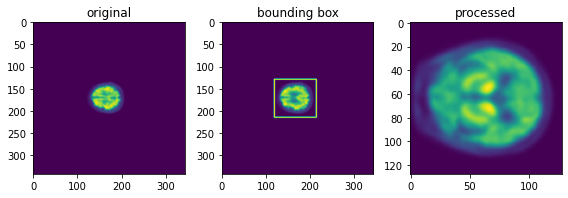

In [ ]:
test_img = np.array(nib.load(pos_pet[0]).dataobj)
test_img = np.mean(test_img, axis=3)
print(test_img.shape)
r_pos = process_scan(pos_pet[0])
print(r_pos.shape)
fig, ax = plt.subplots(1, 3, figsize=(8, 8))
ax[0].imshow((np.array(test_img))[:, :, 65])
ax[0].set_title("original")
index = int(test_img.shape[2] / 2) - int(20 / 2)
sliced = test_img[:, :, index : index + 20]
rect = find_brain_bounding_box(sliced)
ax[1].imshow(
    cv2.rectangle(
        normalize(sliced[:, :, int(sliced.shape[2] / 2)]),
        (rect[0], rect[1]),
        (rect[2], rect[3]),
        1,
        2,
    ).get()
)
ax[1].set_title("bounding box")
ax[2].imshow(r_pos[:, :, 10])
ax[2].set_title("processed")
plt.tight_layout()
plt.show()

## Generating the CV Folds

To reduce the required time in later phases, we can pre-compute the cross-validation folds. We start by splitting the dataset into a train-test set (using the 20% as test split). Note that in the following code the "test set" is referred to as "validation set" due to a coding error: sadly, due to the size of the final dataset, it is pretty expensive to move and rename the folder and its files.

In [ ]:
import pickle

if FIRST_RUN:
    pos_pet = [str(s) for s in DATA_DIR.glob("pet/positive/*.hdr")]
    neg_pet = [str(s) for s in DATA_DIR.glob("pet/negative/*.hdr")]
    mod_pet = [str(s) for s in DATA_DIR.glob("pet/modified/*.nii")]
    # Saving the paths of every scans in text file for faster reading

    pet_pos_paths = open(DATA_DIR / "csv" / "pet_pos_paths.txt", "wb")
    pickle.dump(pos_pet, pet_pos_paths)
    pet_pos_paths.close()

    pet_neg_paths = open(DATA_DIR / "csv" / "pet_neg_paths.txt", "wb")
    pickle.dump(neg_pet, pet_neg_paths)
    pet_neg_paths.close()

    pet_mod_paths = open(DATA_DIR / "csv" / "pet_mod_paths.txt", "wb")
    pickle.dump(mod_pet, pet_mod_paths)
    pet_mod_paths.close()
else:
    pos_pet = pickle.load(open(DATA_DIR / "csv" / "pet_pos_paths.txt", "rb"))
    neg_pet = pickle.load(open(DATA_DIR / "csv" / "pet_neg_paths.txt", "rb"))
    mod_pet = pickle.load(open(DATA_DIR / "csv" / "pet_mod_paths.txt", "rb"))

In [ ]:
sample = pd.read_csv(DATA_DIR / "csv/new_sample.csv").drop(columns=["tracer"])
sample.sort_values(["Subject", "Date"], inplace=True)
sample.drop_duplicates(subset=["Subject"], keep="last", inplace=True)
sample = sample[
    sample["MRId"].map(
        lambda x: x
        not in [
            "OAS30031_MR_d0236",
            "OAS30078_MR_d0136",
            "OAS30144_MR_d1708",
            "OAS30650_MR_d1620",
            "OAS31135_MR_d0096",
            "OAS31140_MR_d0148",
            "OAS31171_MR_d0441",
            "OAS30058_MR_d0836",
            "OAS30297_MR_d2331",
        ]
    )
]
sample.to_csv(DATA_DIR / "csv/pet_sample.csv", index=False)
sample

In [ ]:
sample = pd.read_csv(DATA_DIR / "csv/pet_sample.csv")
sample["Label"].value_counts()
sample.sort_values(["Label"], ascending=False, inplace=True)

In [ ]:
sample.head()

,PUP_PUPTIMECOURSEDATA ID,Date,Subject,Label
204,OAS30964_AV45_PUPTIMECOURSE_d3870,3870,OAS30964,True
137,OAS30662_PIB_PUPTIMECOURSE_d3157,3157,OAS30662,True
199,OAS30947_PIB_PUPTIMECOURSE_d0840,840,OAS30947,True
200,OAS30948_AV45_PUPTIMECOURSE_d0076,76,OAS30948,True
84,OAS30399_PIB_PUPTIMECOURSE_d1184,1184,OAS30399,True


In [ ]:
mod_pet = pd.read_csv(DATA_DIR / "csv/modified-pet.csv")
mod_pet.drop(columns=["Unnamed: 0"], inplace=True)
mod_pet.to_csv(DATA_DIR / "csv/modified-pet.csv")
mod_pet["Label"] = True

In [ ]:
for i, row in mod_pet.iterrows():
    row["PUP_PUPTIMECOURSEDATA ID"] = (
        row["PUP_PUPTIMECOURSEDATA ID"] + f"_mod{i}.4dfp.nii"
    )
mod_pet.head()

,PUP_PUPTIMECOURSEDATA ID,Date,Subject,Label
0,OAS30931_PIB_d0489n_moco,"Series([], Name: Date, dtype: int64)",OAS30931,True
1,OAS30784_PIB_d0162n_moco,"Series([], Name: Date, dtype: int64)",OAS30784,True
2,OAS30899_PIB_d2324n_moco,"Series([], Name: Date, dtype: int64)",OAS30899,True
3,OAS30114_AV45_d0086n_moco,"Series([], Name: Date, dtype: int64)",OAS30114,True
4,OAS30472_PIB_d1278n_moco,"Series([], Name: Date, dtype: int64)",OAS30472,True


In [ ]:
mod_pet["PUP_PUPTIMECOURSEDATA ID"].map(lambda x: (x + f"_mod{i}.4dfp.nii"))

,PUP_PUPTIMECOURSEDATA ID,Date,Subject,Label
0,OAS30931_PIB_d0489n_moco,"Series([], Name: Date, dtype: int64)",OAS30931,True
1,OAS30784_PIB_d0162n_moco,"Series([], Name: Date, dtype: int64)",OAS30784,True
2,OAS30899_PIB_d2324n_moco,"Series([], Name: Date, dtype: int64)",OAS30899,True
3,OAS30114_AV45_d0086n_moco,"Series([], Name: Date, dtype: int64)",OAS30114,True
4,OAS30472_PIB_d1278n_moco,"Series([], Name: Date, dtype: int64)",OAS30472,True


In [ ]:
sample = sample.reset_index()
train_pos = sample[:75]
test_pos = sample[75:105]
train_neg = sample[105:223]
test_neg = sample[223:]
trainset = pd.concat([train_pos, train_neg])
print(trainset["Label"].value_counts())
trainset = pd.concat([mod_pet, trainset], ignore_index=True)
print(trainset["Label"].value_counts())
testset = pd.concat([test_pos, test_neg], ignore_index=True)
print(testset["Label"].value_counts())
xtrain = trainset
xtrain.replace({False: 0, True: 1}, inplace=True)
ytrain = xtrain["Label"].to_numpy()
xtrain.drop(columns=["Label", "Date", "Subject"], inplace=True)
xtrain = xtrain["PUP_PUPTIMECOURSEDATA ID"].to_numpy()
np.save(DATA_DIR / "pet" / "subjects_xtrain.npy", xtrain)
np.save(DATA_DIR / "pet" / "subjects_ytrain.npy", ytrain)

xtest = testset
xtest.replace({False: 0, True: 1}, inplace=True)
ytest = xtest["Label"].to_numpy()
xtest.drop(columns=["Label", "Date", "Subject"], inplace=True)
xtest = xtest["PUP_PUPTIMECOURSEDATA ID"].to_numpy()
np.save(DATA_DIR / "pet" / "subjects_xtest.npy", xtest)
np.save(DATA_DIR / "pet" / "subjects_ytest.npy", ytest)

False    118
True      75
Name: Label, dtype: int64
True     118
False    118
Name: Label, dtype: int64
True     30
False    30
Name: Label, dtype: int64


In [ ]:
xtrain = np.load(DATA_DIR / "pet" / "subjects_xtrain.npy", allow_pickle=True)
xtest = np.load(DATA_DIR / "pet" / "subjects_xtest.npy", allow_pickle=True)
new_x_test = list(
    (
        map(
            lambda x: re.sub(
                r"(^OAS\d+\_)(AV45|PIB)_PUPTIMECOURSE_(d\d+)", r"\1\2_\3n_moco", x
            ),
            xtest,
        )
    )
)
new_x_train = list(
    (
        map(
            lambda x: re.sub(
                r"(^OAS\d+\_)(AV45|PIB)_PUPTIMECOURSE_(d\d+)", r"\1\2_\3n_moco", x
            ),
            xtrain,
        )
    )
)

In [ ]:
import pickle

xtrain = np.load(DATA_DIR / "pet" / "subjects_xtrain.npy", allow_pickle=True)
xtest = np.load(DATA_DIR / "pet" / "subjects_xtest.npy", allow_pickle=True)
new_x_test = list(
    (
        map(
            lambda x: re.sub(
                r"(^OAS\d+\_)(AV45|PIB)_PUPTIMECOURSE_(d\d+)", r"\1\2_\3n_moco", x
            ),
            xtest,
        )
    )
)
new_x_train = list(
    (
        map(
            lambda x: re.sub(
                r"(^OAS\d+\_)(AV45|PIB)_PUPTIMECOURSE_(d\d+)", r"\1\2_\3n_moco", x
            ),
            xtrain,
        )
    )
)
pos_pet = pickle.load(open(DATA_DIR / "csv" / "pet_pos_paths.txt", "rb"))
neg_pet = pickle.load(open(DATA_DIR / "csv" / "pet_neg_paths.txt", "rb"))
mod_pet = pickle.load(open(DATA_DIR / "csv" / "pet_mod_paths.txt", "rb"))
pet = pos_pet + neg_pet + mod_pet
map_pet = [s.split("/")[-1].split(".")[0] for s in pet]
pet = dict(zip(map_pet, pet))
train_paths = list(map(lambda s: pet[s], new_x_train))
test_paths = list(map(lambda s: pet[s], new_x_test))

In [ ]:
print(len(train_paths), len(test_paths))

236 60


In [ ]:
# x_train = np.load(DATA_DIR/'pet/xtrain-pickle.npy', allow_pickle=True)
x_test = np.load(DATA_DIR / "pet/xtest-pickle.npy", allow_pickle=True)
x_test.shape
# xtrain = np.concatenate(x_train,axis = 2).T
# xtest = np.concatenate(x_test,axis = 2).T

In [ ]:
a = np.load(DATA_DIR / "pet/xtest-pickle.npy", allow_pickle=True)
a.shape

(128, 128, 50)

In [ ]:
for i, img in enumerate(test_paths):
    x = process_scan(img)
    if x.shape[2] == 20 and x is not None:
        np.save(DATA_DIR / f"pet/test/{i}.npy", x)
    else:
        print(f"{i} broken")

In [ ]:
x = process_scan(train_paths[2])
i = 2
print(x.shape)
np.save(DATA_DIR / f"pet/train/{i}.npy", x)

(128, 128, 50)


In [ ]:
!ls "$DATA_DIR/pet/train" | wc -l

229


In [ ]:
for i, img in enumerate(train_paths):
    x = process_scan(img)
    if x is not None:
        if x.shape[2] == 50:
            np.save(DATA_DIR / f"pet/train/{i}.npy", x)
    else:
        print(f"{i} broken")

Error in reading /datasets/drive/MyDrive/Thesis/data/pet/positive/OAS30355_AV45_d0861n_moco.4dfp.hdr (file could be damaged)


55 broken


Error in reading /datasets/drive/MyDrive/Thesis/data/pet/positive/OAS30510_PIB_d1259n_moco.4dfp.hdr (file could be damaged)


73 broken


Error in reading /datasets/drive/MyDrive/Thesis/data/pet/positive/OAS30901_AV45_d0155n_moco.4dfp.hdr (file could be damaged)


80 broken


Error in reading /datasets/drive/MyDrive/Thesis/data/pet/negative/OAS31022_AV45_d0089n_moco.4dfp.hdr (file could be damaged)


150 broken


Error in reading /datasets/drive/MyDrive/Thesis/data/pet/negative/OAS30279_AV45_d0136n_moco.4dfp.hdr (file could be damaged)


180 broken


Error in reading /datasets/drive/MyDrive/Thesis/data/pet/negative/OAS30220_AV45_d1165n_moco.4dfp.hdr (file could be damaged)


193 broken


Error in reading /datasets/drive/MyDrive/Thesis/data/pet/negative/OAS30105_AV45_d0056n_moco.4dfp.hdr (file could be damaged)


203 broken


In [ ]:
ytrain = np.load(DATA_DIR / "pet" / "subjects_ytrain.npy")
ytrain.shape

(236,)

In [ ]:
yt = np.delete(ytrain, [55, 73, 80, 150, 180, 193, 203])
y_train = np.concatenate(list(map(lambda x: [x] * 50, yt)))
print(y_train.shape)
np.save(DATA_DIR / "pet/ytrain.npy", y_train)

(11450,)


In [ ]:
# Code for 3D 50 frames
train_images = DATA_DIR.glob("pet/train/*.npy")
x_train = np.array([np.load(path, allow_pickle=True) for path in train_images])
test_images = DATA_DIR.glob("pet/test/*.npy")
x_test = np.array([np.load(path, allow_pickle=True) for path in test_images])
np.save(DATA_DIR / "pet/50-xtrain.npy", x_train)
np.save(DATA_DIR / "pet/50-xtest.npy", x_test)

In [ ]:
y_train = np.load(DATA_DIR / "pet" / "subjects_ytrain.npy")
print(y_train.shape)
y_test = np.load(DATA_DIR / "pet" / "subjects_ytest.npy")
yt = np.delete(ytrain, [55, 73, 80, 150, 180, 193, 203])
y_train = yt
print(y_test.shape)

(236,)
(60,)


In [ ]:
train_images = DATA_DIR.glob("pet/train/*.npy")
x = np.array([np.load(path, allow_pickle=True) for path in train_images])
x_train = np.concatenate(x, axis=2).T

test_images = DATA_DIR.glob("pet/test/*.npy")
z = np.array([np.load(path, allow_pickle=True) for path in test_images])
x_test = np.concatenate(z, axis=2).T

np.save(DATA_DIR / "pet/xtrain_arr.npy", x_train)
np.save(DATA_DIR / "pet/xtest_arr.npy", x_test)

In [ ]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(229, 128, 128, 50) (60, 128, 128, 50) (229,) (60,)


In [ ]:
np.save(DATA_DIR / "pet/20-xtrain.npy", train_img)
np.save(DATA_DIR / "pet/20-xtest.npy", test_img)

In [ ]:
ytest = np.load(DATA_DIR / "pet" / "subjects_ytest.npy")
ytrain = np.load(DATA_DIR / "pet" / "subjects_ytrain.npy")
y_test = np.concatenate(list(map(lambda x: [x] * 20, ytest)))
y_train = np.concatenate(list(map(lambda x: [x] * 20, ytrain)))
np.save(DATA_DIR / "pet/20-ytrain.npy", y_train)
np.save(DATA_DIR / "pet/20-ytest.npy", y_test)

In [ ]:
ytest = np.load(DATA_DIR / "pet" / "subjects_ytest.npy")
ytrain = np.load(DATA_DIR / "pet" / "subjects_ytrain.npy")
# test_img = np.array(list(filter(lambda x: x is not None and np.array(x).shape[-1] ==50, p_uimap(process_scan, test_paths))))
# x_test = np.concatenate(test_img,axis = 2).T
y_test = np.concatenate(list(map(lambda x: [x] * 50, ytest)))
np.save(DATA_DIR / "pet/xtest.npy", test_img)
np.save(DATA_DIR / "pet/ytest.npy", y_test)

In [ ]:
train_img = np.array(
    list(
        filter(
            lambda x: x is not None and np.array(x).shape[-1] == 30,
            p_uimap(process_scan, train_paths),
        )
    )
)
test_img = np.array(
    list(
        filter(
            lambda x: x is not None and np.array(x).shape[-1] == 30,
            p_uimap(process_scan, test_paths),
        )
    )
)

In [ ]:
np.save(DATA_DIR / "pet/30-xtrain.npy", train_img)
np.save(DATA_DIR / "pet/30-xtest.npy", test_img)

In [ ]:
train_img = np.array(
    list(
        filter(
            lambda x: x is not None and np.array(x).shape[-1] == 20,
            p_uimap(process_scan, train_paths),
        )
    )
)
test_img = np.array(
    list(
        filter(
            lambda x: x is not None and np.array(x).shape[-1] == 20,
            p_uimap(process_scan, test_paths),
        )
    )
)
x_train = np.concatenate(train_img, axis=2).T
x_test = np.concatenate(test_img, axis=2).T
np.save(DATA_DIR / "pet/xtrain.npy", x_train)
np.save(DATA_DIR / "pet/xtest.npy", test_img)

In [ ]:
y_train = np.concatenate(list(map(lambda x: [x] * 50, ytrain)))
y_test = np.concatenate(list(map(lambda x: [x] * 50, ytest)))
np.save(DATA_DIR / "pet/ytrain.npy", y_train)
np.save(DATA_DIR / "pet/ytest.npy", y_test)

In [ ]:
from sklearn.model_selection import train_test_split

VAL_SIZE = 0.2
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=VAL_SIZE)

base = DATA_DIR / "pet/folds/validation/"
base.mkdir(parents=True, exist_ok=True)
np.save(base / "xtrain.npy", x_train)
np.save(base / "xval.npy", x_val)
np.save(base / "ytrain.npy", y_train)
np.save(base / "yval.npy", y_val)

We can then apply a repeated stratified 10-fold cross validation on the previously created train set by saving each fold to a file. Each fold will then be used as validation set in future steps.

In [ ]:
y_test = np.load(DATA_DIR / "pet" / "50-ytest.npy")
y_train = np.load(DATA_DIR / "pet" / "50-ytrain.npy")
x_test = np.load(DATA_DIR / "pet" / "50-xtest.npy")
x_train = np.load(DATA_DIR / "pet" / "50-xtrain.npy")

In [ ]:
print(y_test.shape, y_train.shape, x_train.shape, x_test.shape)

(60,) (229,) (229, 128, 128, 20) (60, 128, 128, 20)


In [ ]:
from sklearn.model_selection import StratifiedKFold

base = DATA_DIR / "pet/3d-folds/20"
kFold = StratifiedKFold(n_splits=10, random_state=RANDOM_SEED, shuffle=True)
traintest = kFold.split(x_train, y_train)

for k, (train, test) in enumerate(traintest):
    print("k =", k + 1)
    fold_dir = base / f"fold-{k + 1}"
    fold_dir.mkdir(parents=True, exist_ok=True)

    np.save(fold_dir / "xtrain.npy", x_train[train])
    np.save(fold_dir / "ytrain.npy", y_train[train])
    np.save(fold_dir / "xtest.npy", x_train[test])
    np.save(fold_dir / "ytest.npy", y_train[test])

k = 1
k = 2
k = 3
k = 4
k = 5
k = 6
k = 7
k = 8
k = 9
k = 10
